In [2]:
import pandas as pd
import os
import seaborn as sb
from PIL import Image
import matplotlib.pyplot as plt
from numpy import expand_dims
import numpy as np
from skimage.io import imread_collection
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from sklearn.metrics import confusion_matrix  
from tensorflow.keras import models,layers,optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications import Xception
import pickle
import cv2
import warnings
warnings.filterwarnings('ignore')

# Data exploration

In [2]:
# check directory
os.getcwd()

'C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection'

In [10]:
# read csv files containing the labels and sample submission
os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\state-farm-distracted-driver-detection')
driver_imgs_list = pd.read_csv('driver_imgs_list.csv')
sample_submission = pd.read_csv('sample_submission.csv')

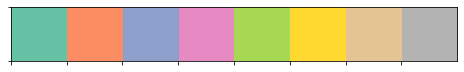

In [4]:
# set default palette
palette='Set2'
sb.set_palette(palette)
sb.palplot(sb.color_palette(palette))

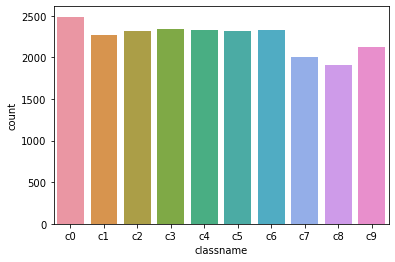

In [5]:
# the distribution of class labels reasonably balanced
sb.countplot(x=driver_imgs_list['classname'])

In [6]:
# the meanings of each label are as follows
corresponding_class_labels={'c0': 'safe driving',
                            'c1': 'texting - right',
                            'c2': 'talking on the phone - right',
                            'c3': 'texting - left',
                            'c4': 'talking on the phone - left',
                            'c5': 'operating the radio',
                            'c6': 'drinking',
                            'c7': 'reaching behind',
                            'c8': 'hair and makeup',
                            'c9': 'talking to passenger'}

In [7]:
# pick 2 random images from each class
samples_to_visualise={}
for group in driver_imgs_list.groupby('classname'):
    label=group[0]
    df=group[1]
    samples_to_visualise[label]=df.sample(2).img.values

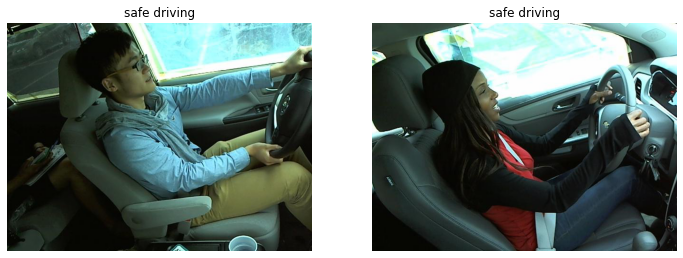

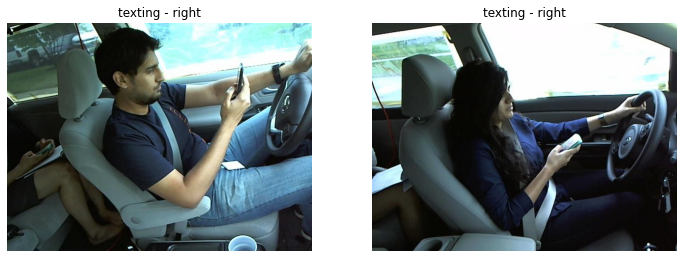

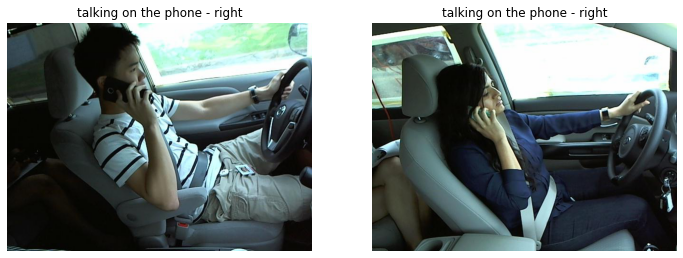

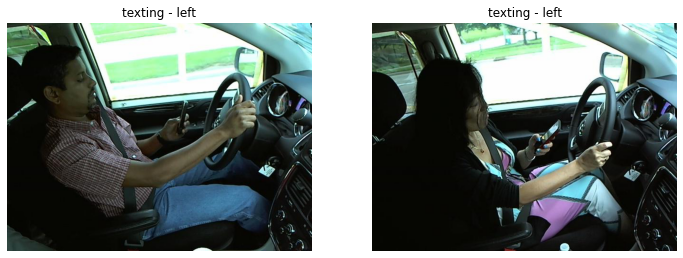

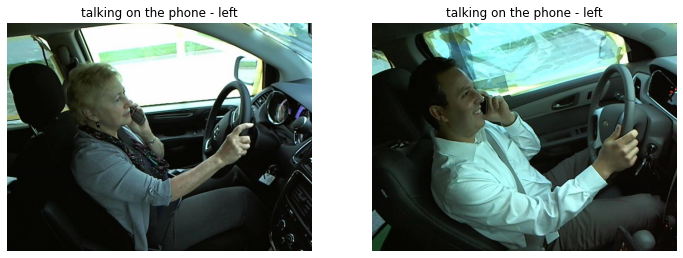

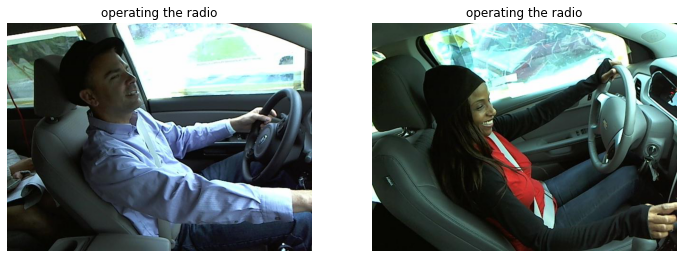

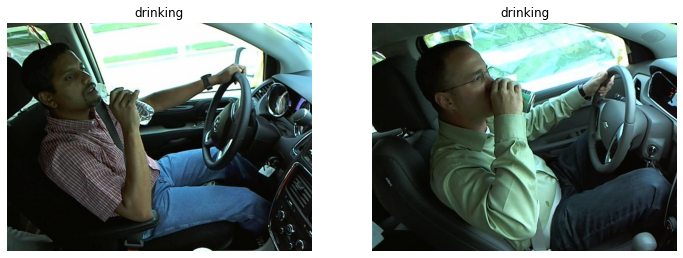

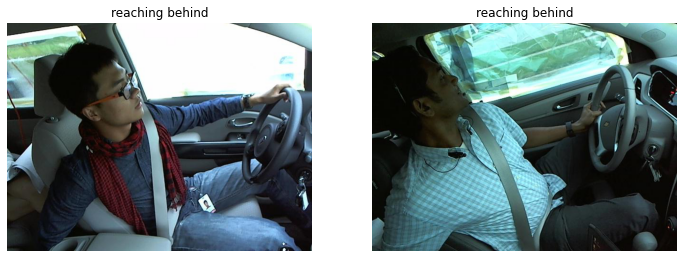

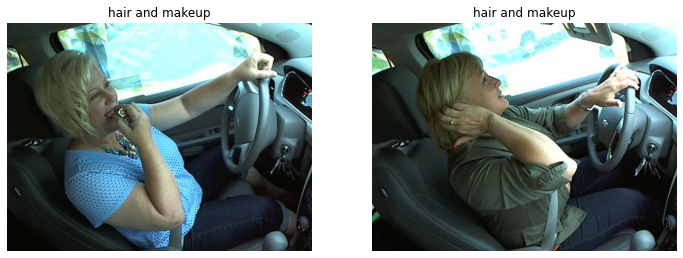

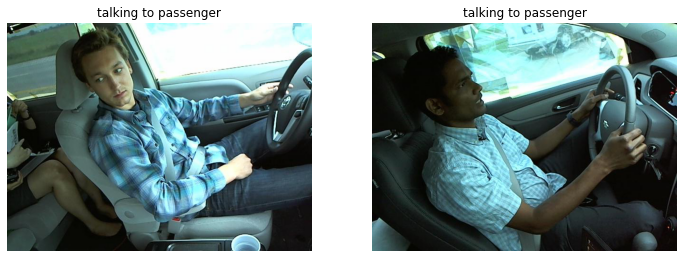

In [8]:
# visualise 2 random images of each class
for key in corresponding_class_labels.keys():
    
    # extract the images from respective directories
    os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\state-farm-distracted-driver-detection\\train\\'+key)
    label=corresponding_class_labels[key]
    img1_id,img2_id=samples_to_visualise[key]
    image_list = [Image.open(img1_id), Image.open(img2_id)]
    
    
    fig, ax = plt.subplots(1,2,figsize=(12,8))
    for i in range(2):
        ax[i].imshow(image_list[i])
        # the following removes ticks and spines of the image
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(label)
    plt.show()


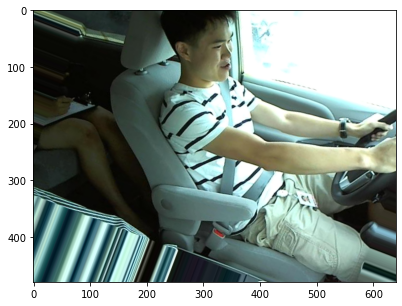

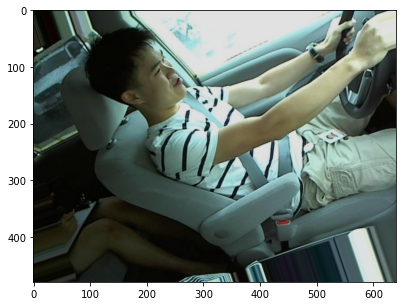

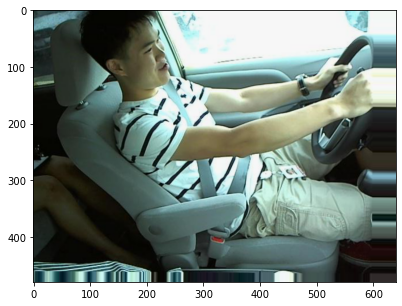

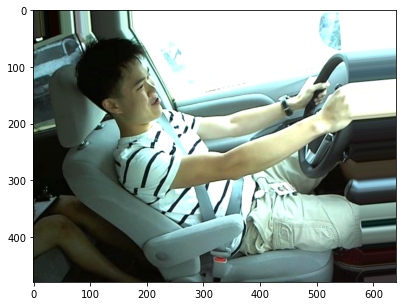

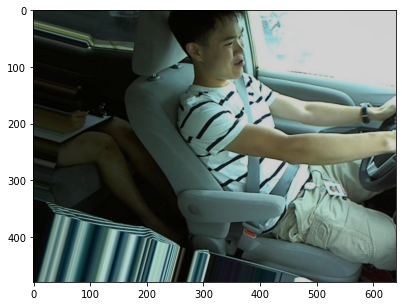

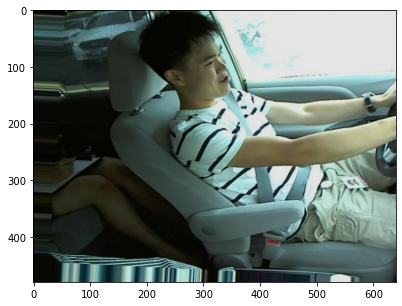

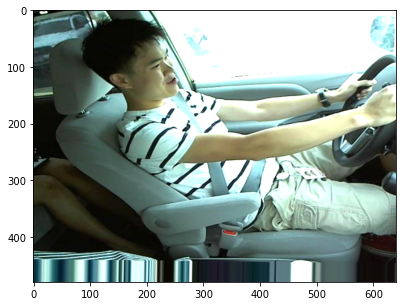

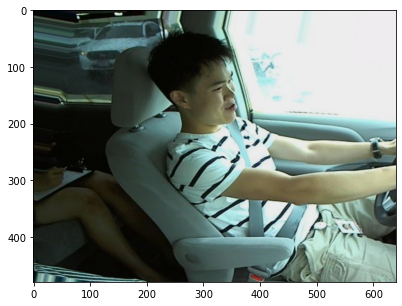

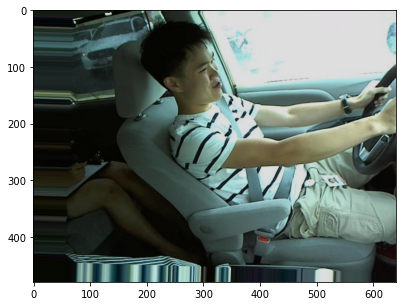

In [9]:
# view some augmented images
os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\state-farm-distracted-driver-detection\\train\\c0')
img = load_img('img_44733.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)
datagen = ImageDataGenerator(validation_split=0.2,
                            rotation_range=30,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            brightness_range=(0.8,1.2),
                            zoom_range=0.1)
it = datagen.flow(samples, batch_size=1)
for i in range(9):
    f, axes = plt.subplots(1,1 , figsize=(15,5)) 
    batch = it.next()
    image = batch[0].astype('uint8') 
    plt.imshow(image)
plt.show()

In [10]:
print('Total of {} samples in the training set'.format(len(driver_imgs_list)))

Total of 22424 samples in the training set


# Train model on non-augmented images

In [13]:
# directory containing training images
data_dir= 'C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\state-farm-distracted-driver-detection\\train'

In [14]:
# these instances augment the data
train_datagen=ImageDataGenerator(rescale = 1./255, 
                                 validation_split=0.2)#,
#                                  rotation_range=30,
#                                  width_shift_range=0.1,
#                                  height_shift_range=0.1,
#                                  brightness_range=(0.8,1.2),
#                                  zoom_range=0.1)
val_datagen = ImageDataGenerator(rescale = 1./255, 
                                 validation_split=0.2)

 # generates training data      
train_generator = train_datagen.flow_from_directory(data_dir, 
                                                    # photos are resized to 150 x 150 
                                                   target_size = (180,180),
                                                    # IMPT: images are generated in batches of 20
                                                   batch_size = 32,
                                                   # multi-class classification
                                                   class_mode = 'categorical',
                                                    # specify this as training set, 80%
                                                   subset='training',
                                                    # SET SEED SO VALIDATION AND TRAINING DON"T OVERLAP!
                                                   seed=1)
# generates validation data
validation_generator = val_datagen.flow_from_directory(data_dir, 
                                                    # photos are resized to 150 x 150 
                                                   target_size = (180,180),
                                                    # photos will come in batches of 20
                                                   batch_size = 32,
                                                   # specify binary classification
                                                   class_mode = 'categorical',
                                                       # specify this as validation set, 20%
                                                   subset='validation',
                                                       # SET SEED SO VALIDATION AND TRAINING DON"T OVERLAP!
                                                    seed=1)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [15]:
# model architecture
model_1 = models.Sequential()                        

# 32 filters of size 3x3  
model_1.add(layers.Conv2D( 32, (3,3), activation='relu', input_shape=(180,180,3)))
# batch normalisation to speed up training and slight regularization
# model_1.add(BatchNormalization())
model_1.add(layers.MaxPooling2D((2,2)))
                         
model_1.add(layers.Conv2D( 64, (3,3), activation='relu',input_shape=(180,180,3))) 
# model_1.add(BatchNormalization())
model_1.add(layers.MaxPooling2D((2,2)))

model_1.add(layers.Conv2D( 128, (3,3), activation='relu',input_shape=(180,180,3))) 
# model_1.add(BatchNormalization())
model_1.add(layers.MaxPooling2D((2,2)))

model_1.add(layers.Conv2D( 128, (3,3), activation='relu',input_shape=(180,180,3))) 
# model_1.add(BatchNormalization())
model_1.add(layers.MaxPooling2D((2,2)))

# flatten to single array 
model_1.add(layers.Flatten())
model_1.add(layers.Dropout(0.5))

model_1.add(layers.Dense(512, activation='relu'))
model_1.add(BatchNormalization())
# 1 neuron for each class
# softmax activation for multiclass classification 
model_1.add(layers.Dense(10, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


- **Batch Normalization actually increases training time**, i will use it only once(at fully connected NN)

In [16]:
model_1.compile(loss='categorical_crossentropy',                        
              optimizer= optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),             
              metrics=['acc'])

In [17]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       1

In [18]:
# apply early stopping to save the model
os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection')
checkpoint_cb = ModelCheckpoint('DL_model_no_augmented_image.h5',
                                save_best_only = True)
                                # if there are no improvements after 10 epochs training stops
early_stopping_cb = EarlyStopping(patience = 5,
                                  restore_best_weights = True)

In [ ]:
# train the model
history_1 = model_1.fit_generator(train_generator,
                                  # each epoch runs through the whole dataset
                                  epochs=200,
                                  # number of batches
                                  steps_per_epoch=561,
                                  # validation set has a separate generator
                                  validation_data=validation_generator, 
                                 validation_steps =141,
                                  # saves the model if it does not improve
                                  callbacks= [checkpoint_cb, early_stopping_cb])

# Train model on augmented images


In [19]:
# directory containing training images
data_dir= 'C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\state-farm-distracted-driver-detection\\train'

In [20]:
# these instances augment the data
train_datagen=ImageDataGenerator(rescale = 1./255, 
                                 validation_split=0.2,
                                 rotation_range=30,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 brightness_range=(0.8,1.2),
                                 zoom_range=0.1)

val_datagen = ImageDataGenerator(rescale = 1./255, 
                                 validation_split=0.2)

 # generates training data      
train_generator = train_datagen.flow_from_directory(data_dir, 
                                                    # photos are resized to 150 x 150 
                                                   target_size = (180,180),
                                                    # IMPT: images are generated in batches of 20
                                                   batch_size = 32,
                                                   # multi-class classification
                                                   class_mode = 'categorical',
                                                    # specify this as training set, 80%
                                                   subset='training',
                                                   # SET SEED!!
                                                   seed=1)
# generates validation data
validation_generator = val_datagen.flow_from_directory(data_dir, 
                                                    # photos are resized to 150 x 150 
                                                   target_size = (180,180),
                                                    # photos will come in batches of 20
                                                   batch_size = 32,
                                                   # specify binary classification
                                                   class_mode = 'categorical',
                                                       # specify this as validation set, 20%
                                                   subset='validation',
                                                   # SET SEED!!
                                                   seed=1)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [21]:
# model architecture
model_2 = models.Sequential()                        

# 32 filters of size 3x3  
model_2.add(layers.Conv2D( 32, (3,3), activation='relu', input_shape=(180,180,3)))
# batch normalisation to speed up training and slight regularization
# model_2.add(BatchNormalization())
model_2.add(layers.MaxPooling2D((2,2)))
                         
model_2.add(layers.Conv2D( 64, (3,3), activation='relu',input_shape=(180,180,3))) 
# model_2.add(BatchNormalization())
model_2.add(layers.MaxPooling2D((2,2)))

model_2.add(layers.Conv2D( 128, (3,3), activation='relu',input_shape=(180,180,3))) 
# model_2.add(BatchNormalization())
model_2.add(layers.MaxPooling2D((2,2)))

model_2.add(layers.Conv2D( 128, (3,3), activation='relu',input_shape=(180,180,3))) 
# model_2.add(BatchNormalization())
model_2.add(layers.MaxPooling2D((2,2)))

# flatten to single array 
model_2.add(layers.Flatten())
model_2.add(layers.Dropout(0.5))

model_2.add(layers.Dense(512, activation='relu'))
model_2.add(BatchNormalization())
# 1 neuron for each class
# softmax activation for multiclass classification 
model_2.add(layers.Dense(10, activation='softmax'))

In [22]:
model_2.compile(loss='categorical_crossentropy',                        
              optimizer= optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),             
              metrics=['acc'])

In [23]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 128)      

In [24]:
# w early stopping we can set epochs to a high number and training will stop itself
os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection')
checkpoint_cb = ModelCheckpoint('DL_model_with_augmented_image.h5',
                                save_best_only = True)
                                # if there are no improvements after 10 epochs training stops
early_stopping_cb = EarlyStopping(patience = 5,
                                  restore_best_weights = True)

In [ ]:
# train the model
history_2 = model_2.fit_generator(train_generator,
                                  # each epoch runs through the whole dataset
                                  epochs=200,
                                  # number of batches
                                  steps_per_epoch=561,
                                  # validation set has a separate generator
                                  validation_data=validation_generator, 
                                 validation_steps =141,
                                  # saves the model if it does not improve
                                  callbacks= [checkpoint_cb, early_stopping_cb])

In [ ]:
# saving new model histories 
os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection')
with open('history_no_augmented_image.pickle', 'wb') as file_pi:    
    pickle.dump(history_1.history, file_pi)
    
with open('history_with_augmented_image.pickle', 'wb') as file_pi:    
    pickle.dump(history_2.history, file_pi)

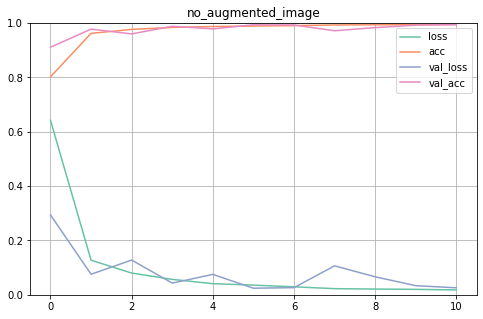

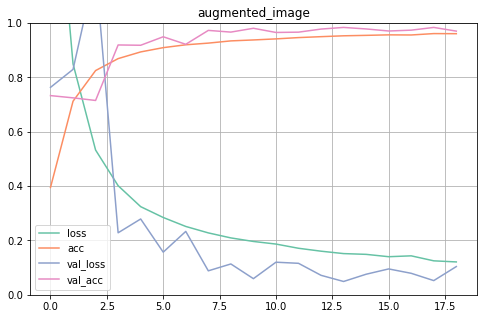

In [25]:
# load past model histories
os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\models')
with open('history_no_augmented_image.pickle', 'rb') as file_pi:
    history_1=pickle.load(file_pi, encoding='bytes')
with open('history_with_augmented_image.pickle', 'rb') as file_pi:
    history_2=pickle.load(file_pi, encoding='bytes')

# comparing CNN model training progression
for hist in [(history_1,'no_augmented_image'),(history_2,'augmented_image')]:
    pd.DataFrame(hist[0]).plot(figsize=(8,5)) 
    plt.grid(True) 
    plt.gca().set_ylim(0,1) 
    plt.title(hist[1])
    plt.show()

- model with augmented image takes much longer to reach convergence

# Making predictions on the test set

In [ ]:
# load models
os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection')
CNN_augmented = models.load_model('DL_model_with_augmented_image.h5')
CNN_neutral = models.load_model('DL_model_no_augmented_image.h5')

In [11]:
def make_predictions(model,output_filename):
    #  directory containing the actual test sub-directory (REQUIRED)
    test_dir='C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\state-farm-distracted-driver-detection\\imgs'
    os.chdir(test_dir)
    # the test folder containing the images must be a SUBDIRECTORY
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(180, 180),
                                                      # 'None' because there are no labels on test set
                                                    class_mode=None,
                                                      # not shuffling will sort in alphanumeric, so that predictions can correspond to filenames later
                                                    shuffle=False,
                                                    batch_size=32)
    # predict images coming from the generator
    predict = model.predict_generator(test_generator,steps = 2492)
    # get file names in alphanumeric order
    filenames_sorted=sorted(os.listdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\state-farm-distracted-driver-detection\\imgs\\test'))

    # create submission Df in correct format
    submission_df=pd.DataFrame(predict,columns=sample_submission.columns[1:])
    submission_df.insert(loc=0,column='img',value=filenames_sorted)

    # store the predictions in desired folder
    os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\predictions')
    submission_df.to_csv(output_filename,index=False)

In [ ]:
make_predictions(model=CNN_augmented, output_filename='CNN_augmented_predictions.csv')
make_predictions(model=CNN_neutral, output_filename='CNN_neutral_predictions.csv')

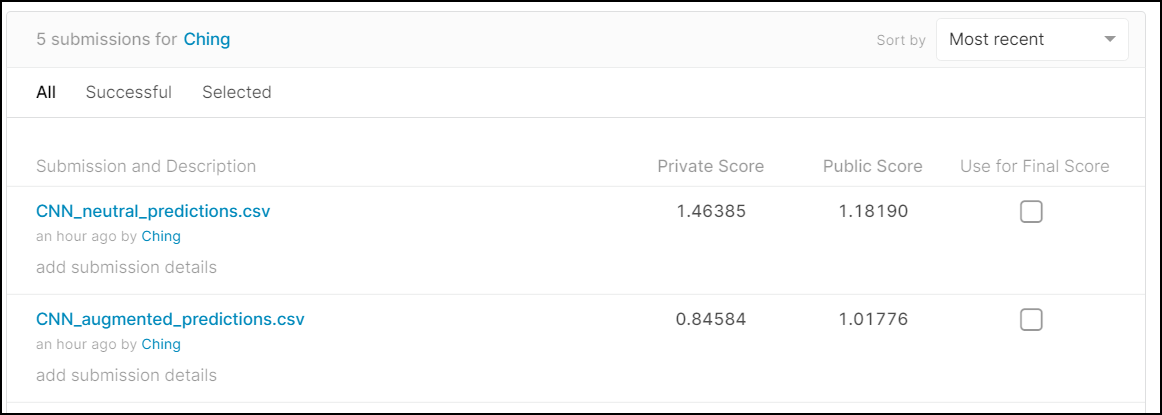

- interestingly, **CNN trained on augmented images outperformed CNN trained on non-augmented images** in kaggle submissions
- CNN trained on augmented images:
    - private score is better than public score, indicating there is little overfitting
- CNN trained non-augmented images:
    - private score is much worse than public score, indicating strong overfitting
   

# Training on full dataset of augmented images

In [40]:
# directory containing training images
data_dir= 'C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\state-farm-distracted-driver-detection\\train'

In [41]:
# using whole data set, no validation
train_datagen=ImageDataGenerator(rescale = 1./255, 
                                 rotation_range=30,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 brightness_range=(0.8,1.2),
                                 zoom_range=0.1)

train_generator = train_datagen.flow_from_directory(data_dir,                                                    
                                                   target_size = (180,180),                                                    
                                                   batch_size = 32,                                    
                                                   class_mode = 'categorical',                                        
                                                   # SET SEED!!
                                                   seed=1)

Found 22424 images belonging to 10 classes.


In [42]:
# model architecture
model_3 = models.Sequential()                        

# 32 filters of size 3x3  
model_3.add(layers.Conv2D( 32, (3,3), activation='relu', input_shape=(180,180,3)))
# batch normalisation to speed up training and slight regularization
# model_2.add(BatchNormalization())
model_3.add(layers.MaxPooling2D((2,2)))
                         
model_3.add(layers.Conv2D( 64, (3,3), activation='relu',input_shape=(180,180,3))) 
# model_2.add(BatchNormalization())
model_3.add(layers.MaxPooling2D((2,2)))

model_3.add(layers.Conv2D( 128, (3,3), activation='relu',input_shape=(180,180,3))) 
# model_2.add(BatchNormalization())
model_3.add(layers.MaxPooling2D((2,2)))

model_3.add(layers.Conv2D( 128, (3,3), activation='relu',input_shape=(180,180,3))) 
# model_2.add(BatchNormalization())
model_3.add(layers.MaxPooling2D((2,2)))

# flatten to single array 
model_3.add(layers.Flatten())
model_3.add(layers.Dropout(0.5))

model_3.add(layers.Dense(512, activation='relu'))
model_3.add(BatchNormalization())
# 1 neuron for each class
# softmax activation for multiclass classification 
model_3.add(layers.Dense(10, activation='softmax'))

In [43]:
model_3.compile(loss='categorical_crossentropy',                        
              optimizer= optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),             
              metrics=['acc'])

In [44]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 18, 18, 128)      

In [45]:
# early stopping and saving the model
os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\models')
# save a model every epoch as 01, 02, 03, 04 etc...  {epoch:03d} saves as 001, 002, 003 etc...
checkpoint_cb = ModelCheckpoint('Model-{epoch:02d}.h5')
                

In [46]:
# train the model
history_3 = model_3.fit_generator(train_generator,
                                  epochs=20,
                                  # 22424 images /32 batch size
                                  steps_per_epoch=701,
                                  # saves the model if it does not improve
                                  callbacks= [checkpoint_cb])

Epoch 1/20
701/701 [==============================] - 1183s 2s/step - loss: 1.4126 - acc: 0.5143
Epoch 2/20
701/701 [==============================] - 1159s 2s/step - loss: 0.6069 - acc: 0.7971
Epoch 3/20
701/701 [==============================] - 1065s 2s/step - loss: 0.4144 - acc: 0.8613
Epoch 4/20
701/701 [==============================] - 1070s 2s/step - loss: 0.3308 - acc: 0.8912
Epoch 5/20
701/701 [==============================] - 1068s 2s/step - loss: 0.2787 - acc: 0.9123
Epoch 6/20
701/701 [==============================] - 1073s 2s/step - loss: 0.2420 - acc: 0.9244
Epoch 7/20
701/701 [==============================] - 1086s 2s/step - loss: 0.2196 - acc: 0.9302
Epoch 8/20
701/701 [==============================] - 1104s 2s/step - loss: 0.1930 - acc: 0.9381
Epoch 9/20
701/701 [==============================] - 1100s 2s/step - loss: 0.1858 - acc: 0.9418
Epoch 10/20
701/701 [==============================] - 1098s 2s/step - loss: 0.1740 - acc: 0.9464
Epoch 11/20
701/701 [========

In [47]:
# saving new model histories 
os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\models')
with open('history_full_augmented_image.pickle', 'wb') as file_pi:    
    pickle.dump(history_3.history, file_pi)

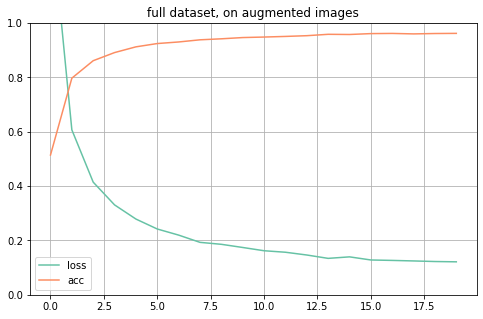

In [48]:
# visualise training progression
pd.DataFrame(history_3.history).plot(figsize=(8,5)) 
plt.grid(True) 
plt.gca().set_ylim(0,1) 
plt.title('full dataset, on augmented images')
plt.show() 

In [12]:
model_epochs=['01','05','10','15','20']
for i in model_epochs:
    os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\models')
    model_round = models.load_model('Model-{}.h5'.format(i))
    os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\predictions')
    make_predictions(model=model_round, output_filename='Model-{}_predictions.csv'.format(i))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Found 79726 images belonging to 1 classes.
Found 79726 images belonging to 1 classes.
Found 79726 images belonging to 1 classes.
Found 79726 images belonging to 1 classes.
Found 79726 images belonging to 1 classes.


In [14]:
model_epochs=['07','08','09','11','12','13']
for i in model_epochs:
    os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\models')
    model_round = models.load_model('Model-{}.h5'.format(i))
    os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\predictions')
    make_predictions(model=model_round, output_filename='Model-{}_predictions.csv'.format(i))

Found 79726 images belonging to 1 classes.
Found 79726 images belonging to 1 classes.
Found 79726 images belonging to 1 classes.
Found 79726 images belonging to 1 classes.
Found 79726 images belonging to 1 classes.
Found 79726 images belonging to 1 classes.


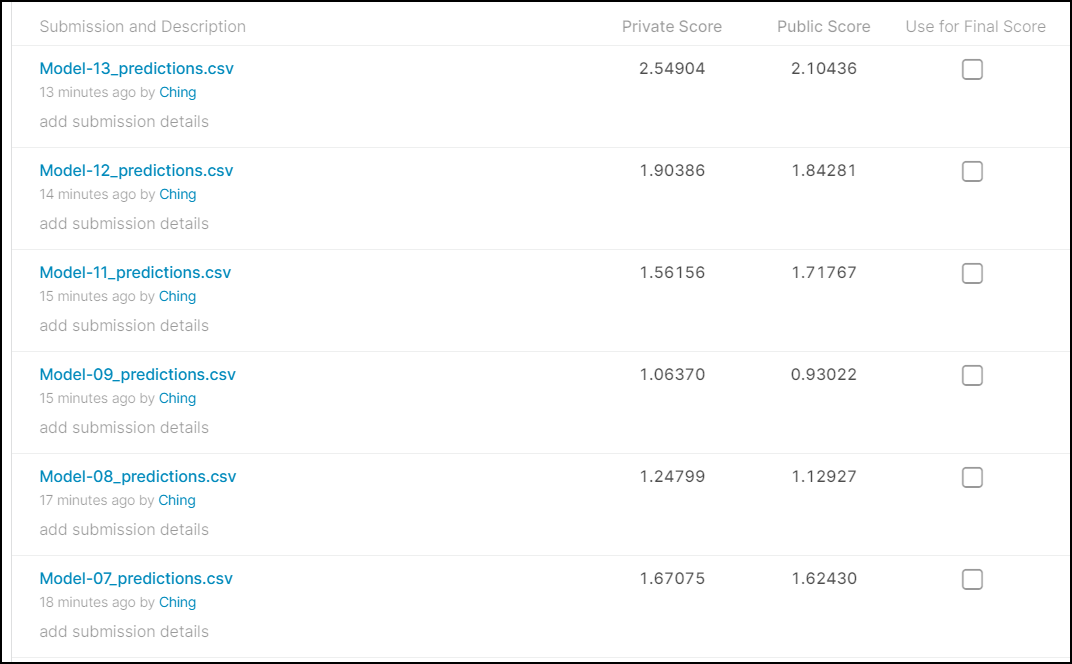

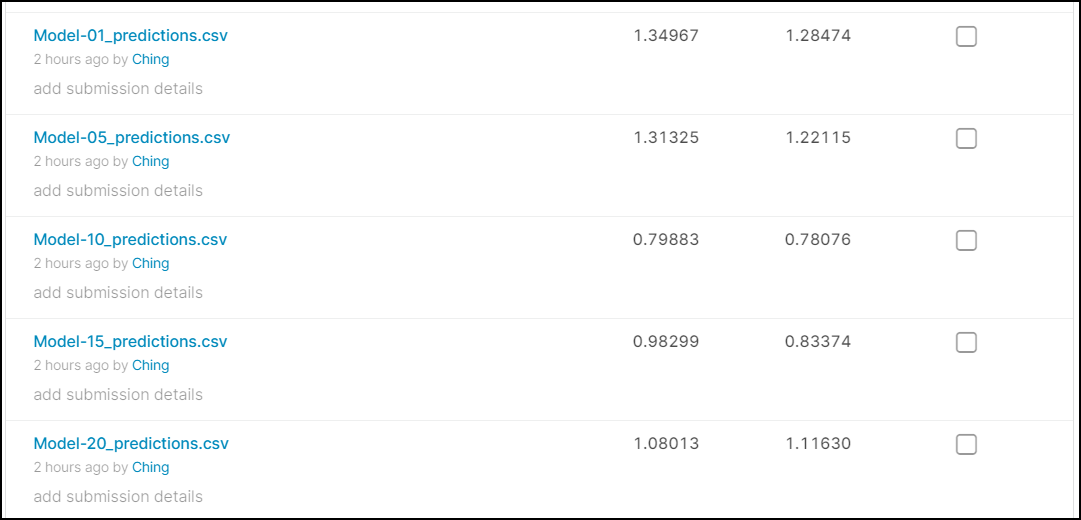

- best score at epoch 10

[Text(0, 0.5, 'LogLoss'),
 Text(0.5, 0, 'epochs'),
 Text(0.5, 1.0, 'Kaggle Performance')]

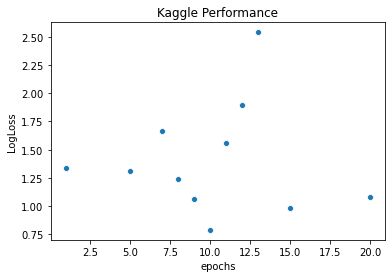

In [31]:
# plot private scores
coordinates = [(1,1.34),(5,1.31),(7,1.67),(8,1.24),(9,1.06),(10,0.79),(11,1.56),(12,1.90),(13,2.54),(15,0.98),(20,1.08)]
sb.scatterplot(x=[element[0] for element in coordinates],
               y=[element[1] for element in coordinates]).set(title='Kaggle Performance',
                                                              xlabel='epochs',
                                                              ylabel='LogLoss')

- **from epochs 1 to 10, there is an improvement/ decrease in logloss**, indicating better generalisation
    - **the peak log loss is at epoch 10**
- beyong 10 epochs, there is no clear trend in model improvement 

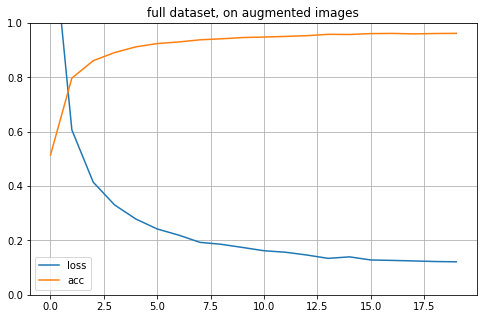

In [32]:
# visualise training progression
os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\Distracted Driver Detection\\models')
with open('history_full_augmented_image.pickle', 'rb') as file_pi:
    history_3=pickle.load(file_pi, encoding='bytes')
pd.DataFrame(history_3).plot(figsize=(8,5)) 
plt.grid(True) 
plt.gca().set_ylim(0,1) 
plt.title('full dataset, on augmented images')
plt.show() 

- **comparing performance in training set and in kaggle, it seems that the model stops generalizing properly the moment performance starts to plateau at epoch 10** 